In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from collections import Counter
from random import seed, sample

# Load the Data

In [2]:
# Load the datasets, ignoring the first column
train_data = pd.read_csv('train.csv',
                         usecols=lambda column: column not in ['Unnamed: 0'])  # Adjust 'Unnamed: 0' if necessary
test_data = pd.read_csv('test.csv',
                        usecols=lambda column: column not in ['Unnamed: 0'])  # Adjust 'Unnamed: 0' if necessary

X_train = train_data[['x', 'y']].values
y_train = train_data['cls'].values

X_test = test_data[['x', 'y']].values
y_test = test_data['cls'].values

# Visualize the Data

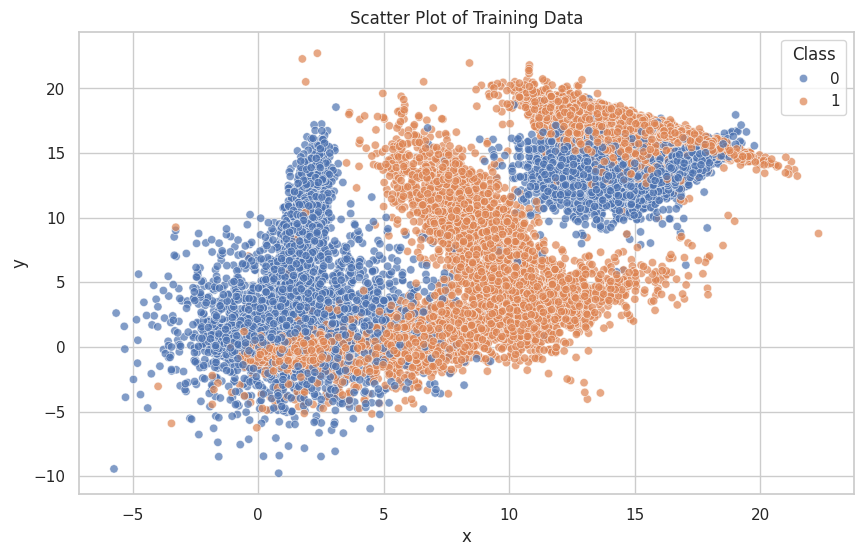

In [ ]:
# Set the style of seaborn
sns.set_theme(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='x', y='y', hue='cls', palette='deep', alpha=0.7)

# Add titles and labels
plt.title('Scatter Plot of Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(title='Class')
plt.show()


# Analyze the Data

In [ ]:
# Check the distribution of classes
class_distribution = train_data['cls'].value_counts()
print(class_distribution)

# Summary statistics of the features
print(train_data.describe())


cls
1    12016
0    11984
Name: count, dtype: int64
                  x             y           cls
count  24000.000000  24000.000000  24000.000000
mean       6.897980      6.840433      0.500667
std        6.638242      6.826364      0.500010
min       -5.739819     -9.763944      0.000000
25%        0.887007      0.421379      0.000000
50%        4.531249      4.941289      1.000000
75%       13.588332     13.693109      1.000000
max       22.312527     22.722494      1.000000


# evaluate model

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predict on training data
    y_train_pred = model.predict(X_train)

    # Calculate metrics for training data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')

    print("Training Metrics:")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"F1 Score: {train_f1:.4f}")
    print(f"Precision: {train_precision:.4f}")
    print(f"Recall: {train_recall:.4f}")
    print()

    # Predict on testing data
    y_test_pred = model.predict(X_test)

    # Calculate metrics for testing data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')

    print("Testing Metrics:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print()


# hyper parameter tuning

In [ ]:
def tune_hyperparameters(model, param_grid, X_train, y_train, scoring='accuracy', cv=5):
    print("Starting hyperparameter tuning...")

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=-1, verbose=1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("\nHyperparameter Tuning Complete!")
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation Score: {best_score:.4f}")

    return best_model


# Param grids

In [ ]:
param_grid_bagging = {
    'n_estimators': [10, 20, 50],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'estimator': [DecisionTreeClassifier(max_depth=5), RandomForestClassifier(n_estimators=10, max_depth=5)]
}

param_grid_bagging_custom = {
    'n_estimators': [5, 10, 20],  # Number of base estimators
    'max_depth': [3, 5, 7],  # Depth of each base tree
    'min_samples_split': [5, 10, 15],  # Minimum samples to split
    'max_samples': [0.6, 0.8, 1.0],  # Proportion of samples per bootstrap
    'base_model': [DecisionTreeClassifier, RandomForestClassifier]
}

param_grid_adaboost = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator': [DecisionTreeClassifier(max_depth=3)]
}

param_grid_random_forest = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

param_grid_random_forest_custom = {
    'n_estimators': [5, 10, 20],  # Number of trees in the forest
    'max_depth': [3, 5, 7],  # Depth of individual trees
    'min_samples_split': [5, 10, 15],  # Minimum samples required to split a node
    'max_features': ['sqrt', 'log2', 0.5, 0.7]  # Features considered at each split
}


# phase1: Bagging

In [3]:
class Bagging:
    def __init__(self, base_model=DecisionTreeClassifier, n_estimators=10, max_depth=5, min_samples_split=5,
                 max_samples=0.7, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_samples = max_samples
        self.random_state = random_state
        self.base_model = base_model
        self.models = []
        self.bootstraps = []

        seed(self.random_state)

    def _bootstrap_sample(self, X, y):
        n_samples = int(len(y) * self.max_samples)
        indices = sample(range(len(y)), n_samples)
        return X[indices], y[indices]

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n_estimators):
            X_bootstrap, y_bootstrap = self._bootstrap_sample(X, y)
            tree = self.base_model(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_bootstrap, y_bootstrap)
            self.models.append(tree)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)

    def get_params(self, deep=True):
        return {
            'base_model': self.base_model,
            'n_estimators': self.n_estimators,
            'random_state': self.random_state
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [ ]:
# Define a function to plot decision boundaries
def plot_decision_boundary(model, X, y, title, ax):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8, cmap='Paired')
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='Paired')
    ax.set_title(title)

Starting hyperparameter tuning...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

Hyperparameter Tuning Complete!
Best Parameters: {'base_model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'max_depth': 7, 'max_samples': 1.0, 'min_samples_split': 15, 'n_estimators': 10}
Best Cross-Validation Score: 0.8723


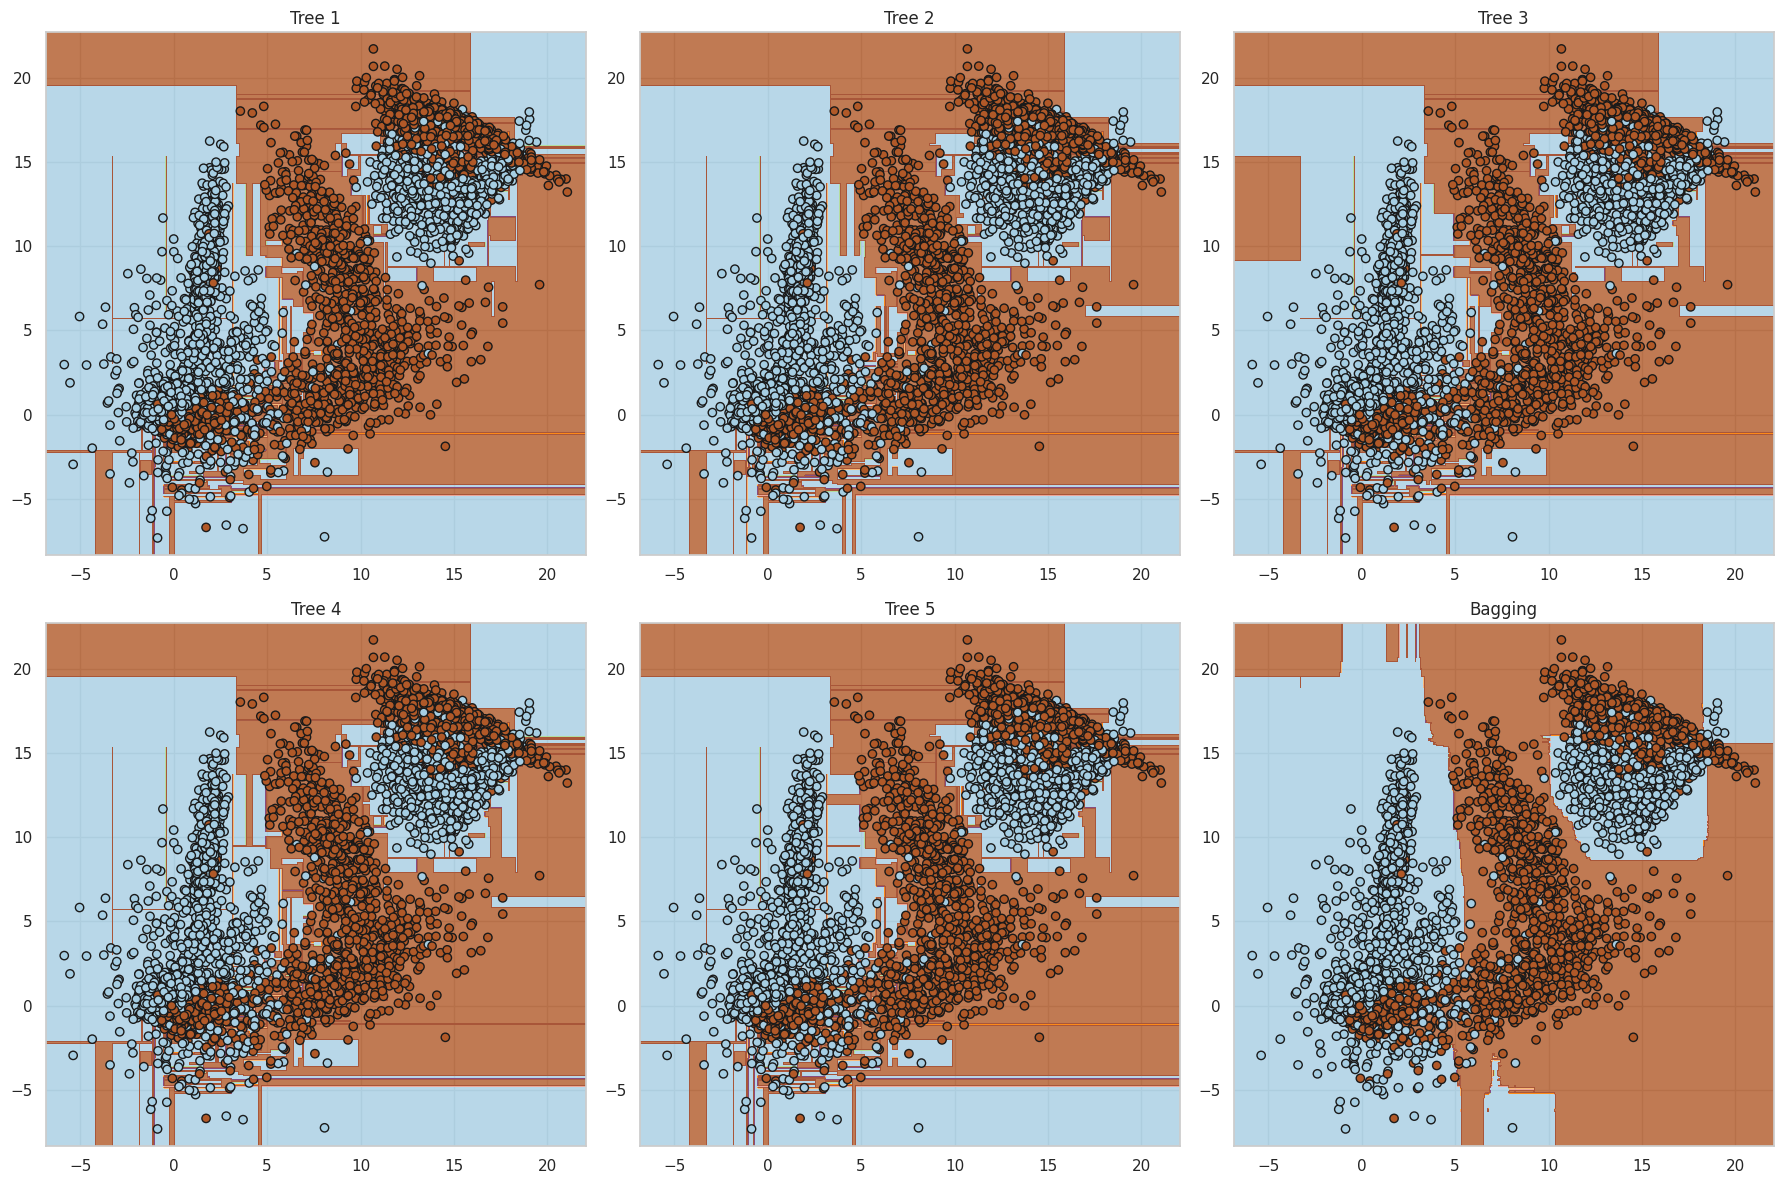

In [ ]:
# Train Bagging ensemble
custom_bagging = tune_hyperparameters(Bagging(), param_grid_bagging_custom, X_train, y_train)

# Train 5 individual Decision Trees
trees = []
for i in range(5):
    tree = DecisionTreeClassifier(random_state=42 + i)
    tree.fit(X_train, y_train)
    trees.append(tree)


# Plot decision boundaries
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Plot each Decision Tree
for i, tree in enumerate(trees):
    plot_decision_boundary(tree, X_test, y_test, f"Tree {i + 1}", axes[i])

# Plot Bagging model
plot_decision_boundary(custom_bagging, X_test, y_test, "Bagging", axes[-1])

plt.tight_layout()
plt.show()


In [ ]:

# Train Bagging ensemble using sklearn's BaggingClassifier
sklearn_bagging = BaggingClassifier()
sklearn_bagging = tune_hyperparameters(sklearn_bagging, param_grid_bagging, X_train, y_train)
sklearn_bagging.fit(X_train, y_train)

evaluate_model(custom_bagging, X_train, y_train, X_test, y_test)
evaluate_model(sklearn_bagging, X_train, y_train, X_test, y_test)


Starting hyperparameter tuning...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Hyperparameter Tuning Complete!
Best Parameters: {'bootstrap': True, 'estimator': RandomForestClassifier(max_depth=5, n_estimators=10), 'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 50}
Best Cross-Validation Score: 0.8616
Training Metrics:
Accuracy: 0.8781
F1 Score: 0.8781
Precision: 0.8787
Recall: 0.8781

Testing Metrics:
Accuracy: 0.8695
F1 Score: 0.8695
Precision: 0.8702
Recall: 0.8695

Training Metrics:
Accuracy: 0.8630
F1 Score: 0.8630
Precision: 0.8631
Recall: 0.8630

Testing Metrics:
Accuracy: 0.8585
F1 Score: 0.8585
Precision: 0.8586
Recall: 0.8585



# Phase 2

In [4]:
class RandomForest:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=5, max_features='sqrt', random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.models = []
        self.bootstraps = []

        seed(self.random_state)

    def _bootstrap_sample(self, X, y):
        n_samples = len(y)
        indices = sample(range(n_samples), n_samples)
        return X[indices], y[indices]

    def _get_max_features(self, n_features):
        if self.max_features == 'sqrt':
            return max(1, int(np.sqrt(n_features)))
        elif self.max_features == 'log2':
            return max(1, int(np.log2(n_features)))
        elif isinstance(self.max_features, int):
            return self.max_features
        else:
            return n_features

    def fit(self, X, y):
        self.models = []
        n_features = X.shape[1]
        max_features = self._get_max_features(n_features)

        for _ in range(self.n_estimators):
            X_bootstrap, y_bootstrap = self._bootstrap_sample(X, y)
            feature_indices = sample(range(n_features), max_features)
            X_subset = X_bootstrap[:, feature_indices]

            tree = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_subset, y_bootstrap)
            self.models.append((tree, feature_indices))

    def predict(self, X):
        predictions = []
        for tree, feature_indices in self.models:
            X_subset = X[:, feature_indices]
            predictions.append(tree.predict(X_subset))

        predictions = np.array(predictions)
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)

    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'random_state': self.random_state,
            'max_features': self.max_features,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


Starting hyperparameter tuning...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Hyperparameter Tuning Complete!
Best Parameters: {'max_depth': 7, 'max_features': 0.7, 'min_samples_split': 5, 'n_estimators': 5}
Best Cross-Validation Score: 0.8638
Starting hyperparameter tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Hyperparameter Tuning Complete!
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Best Cross-Validation Score: 0.8760
Training Metrics:
Accuracy: 0.8758
F1 Score: 0.8757
Precision: 0.8761
Recall: 0.8758

Testing Metrics:
Accuracy: 0.8665
F1 Score: 0.8665
Precision: 0.8669
Recall: 0.8665

Training Metrics:
Accuracy: 0.8924
F1 Score: 0.8924
Precision: 0.8929
Recall: 0.8924

Testing Metrics:
Accuracy: 0.8735
F1 Score: 0.8735
Precision: 0.8741
Recall: 0.8735



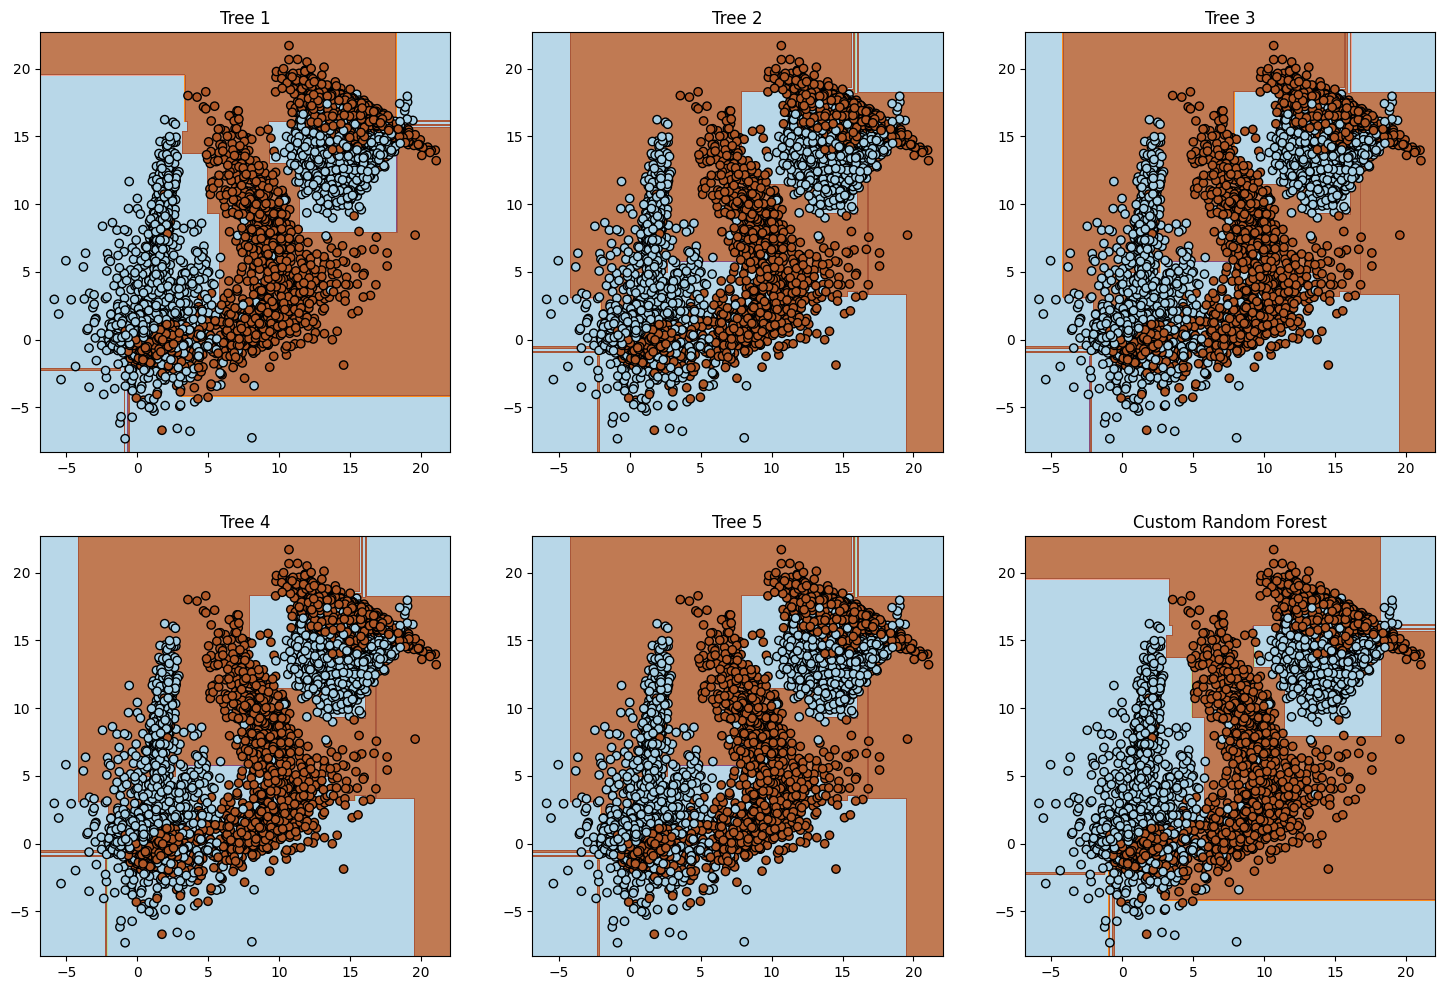

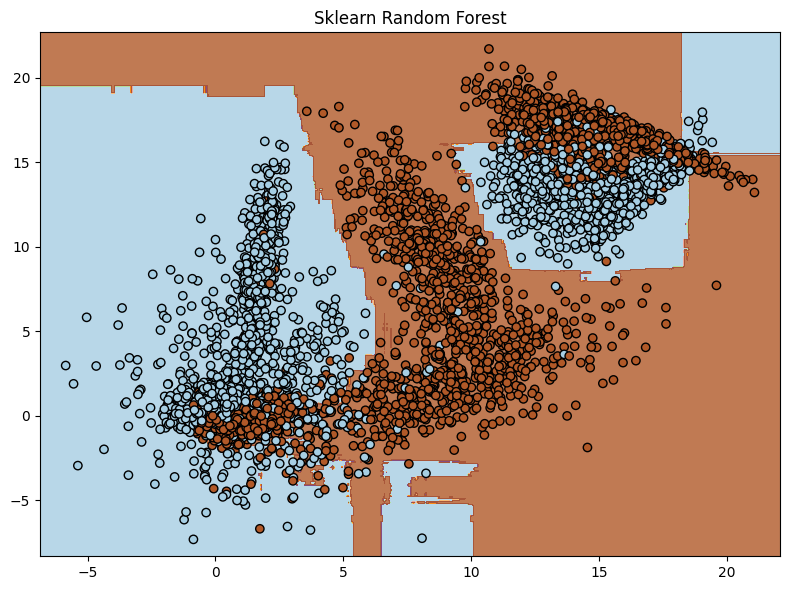

In [ ]:
# Train RandomForest (Custom Implementation)
random_forest = tune_hyperparameters(RandomForest(), param_grid_random_forest_custom, X_train, y_train)
random_forest.fit(X_train, y_train)
custom_rf_predictions = random_forest.predict(X_test)

sklearn_rf = tune_hyperparameters(RandomForestClassifier(), param_grid_random_forest, X_train, y_train)
sklearn_rf.fit(X_train, y_train)
sklearn_rf_predictions = sklearn_rf.predict(X_test)

evaluate_model(random_forest, X_train, y_train, X_test, y_test)
evaluate_model(sklearn_rf, X_train, y_train, X_test, y_test)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create a grid of Axes
axes = axes.ravel()  # Flatten the array of Axes for easier indexing

# Plot decision boundaries for 5 individual trees
for i in range(5):
    plot_decision_boundary(random_forest.models[i][0], X_test, y_test, f"Tree {i + 1}", axes[i])

# Plot decision boundary for Custom Random Forest
plot_decision_boundary(random_forest, X_test, y_test, "Custom Random Forest", axes[5])

# Sklearn Random Forest in a separate plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Create a new figure and Axes
plot_decision_boundary(sklearn_rf, X_test, y_test, "Sklearn Random Forest", ax)

plt.tight_layout()
plt.show()



# phase 3

Starting hyperparameter tuning...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Hyperparameter Tuning Complete!
Best Parameters: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 1.0, 'n_estimators': 100}
Best Cross-Validation Score: 0.8647


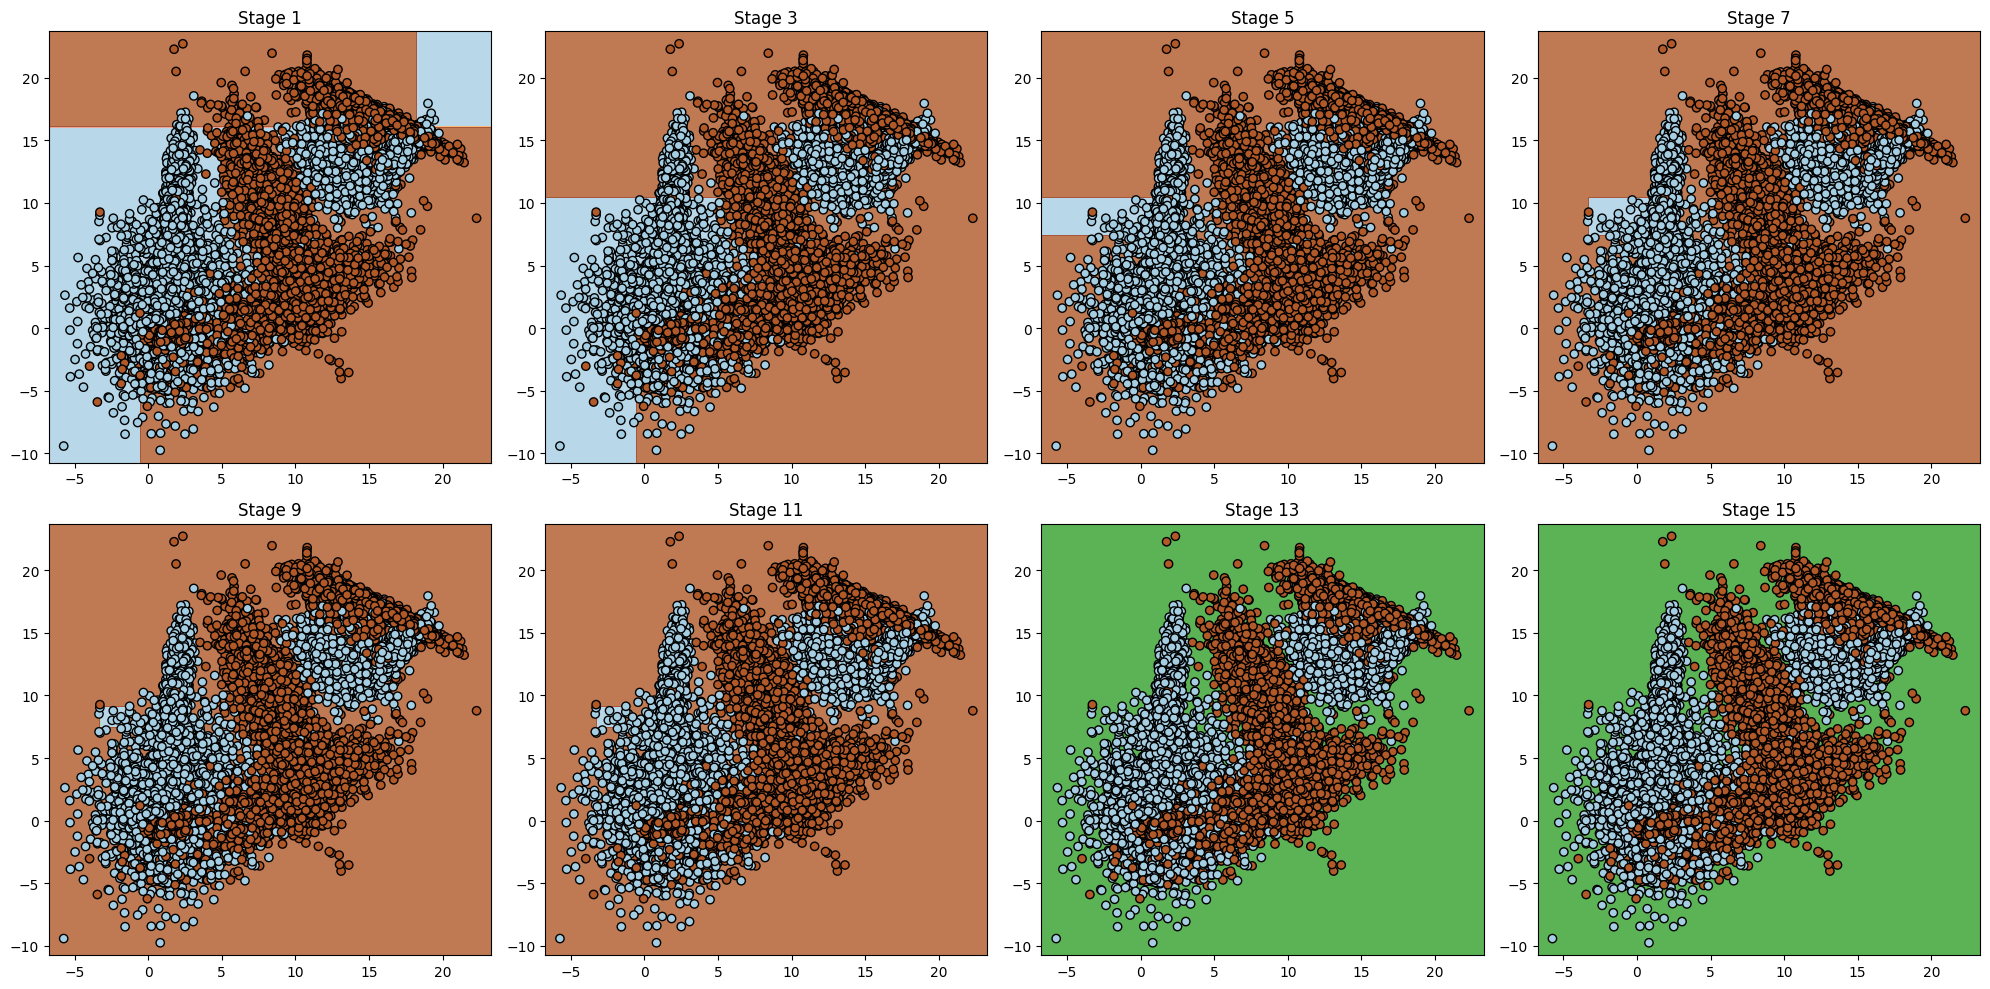

Training Metrics:
Accuracy: 0.8707
F1 Score: 0.8706
Precision: 0.8711
Recall: 0.8707

Testing Metrics:
Accuracy: 0.8635
F1 Score: 0.8635
Precision: 0.8641
Recall: 0.8635



In [15]:
adaboost = tune_hyperparameters(AdaBoostClassifier(algorithm='SAMME'), param_grid_adaboost, X_train, y_train)
adaboost.fit(X_train, y_train)


def plot_adaboost_stage(X, y, adaboost, stage, ax):
    """
    Visualizes the decision boundary at a specific stage of AdaBoost.
    Only considers weak learners up to the given stage.
    """
    # Aggregate predictions up to the specified stage
    stage_estimators = adaboost.estimators_[:stage]  # Get weak learners up to the stage
    stage_weights = adaboost.estimator_weights_[:stage]  # Get weights up to the stage

    def partial_predict(X):
        """Partial predictions up to a specific stage."""
        final_prediction = np.zeros(X.shape[0])
        for estimator, weight in zip(stage_estimators, stage_weights):
            final_prediction += weight * estimator.predict(X)
        return np.sign(final_prediction)  # Return sign of weighted sum

    # Decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = partial_predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot results
    ax.contourf(xx, yy, Z, alpha=0.8, cmap='Paired')
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap='Paired')
    ax.set_title(f"Stage {stage}")


# Visualize 8 selected stages
stages = [1, 3, 5, 7, 9, 11, 13, 15]
_, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, stage in enumerate(stages):
    plot_adaboost_stage(X_train, y_train, adaboost, stage, axes[i])

plt.tight_layout()
plt.show()

evaluate_model(adaboost, X_train, y_train, X_test, y_test)


# Phase 4 & extra point

In [16]:
# Define Base Classifiers
classifiers = {'Random Forest': RandomForestClassifier(random_state=42),
               'SVM': SVC(probability=True, random_state=42),
               'Logistic Regression': LogisticRegression(random_state=42),
               'Decision Tree': DecisionTreeClassifier(random_state=42),
               'Overfitted Tree': DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=42)}

# Hyperparameter Tuning
tuned_classifiers = {}
param_grids = {
    'Random Forest': {'n_estimators': [10, 20, 30], 'max_depth': [None, 10, 20]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10]},
    'Decision Tree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'Overfitted Tree': {'max_depth': [None], 'min_samples_split': [2]}
}

for name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    tuned_classifiers[name] = grid_search.best_estimator_

tuned_classifiers

{'Random Forest': RandomForestClassifier(max_depth=10, n_estimators=30, random_state=42),
 'SVM': SVC(C=10, probability=True, random_state=42),
 'Logistic Regression': LogisticRegression(C=0.1, random_state=42),
 'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=42),
 'Overfitted Tree': DecisionTreeClassifier(random_state=42)}

In [17]:
def train_stacked_classifier(base_classifiers, meta_classifier, X_train, y_train, X_test, y_test):
    """
    Trains a stacked classifier and evaluates it on training and testing data.
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    meta_features_train = np.zeros((X_train.shape[0], len(base_classifiers)))
    meta_features_test = np.zeros((X_test.shape[0], len(base_classifiers)))

    for i, (name, clf) in enumerate(base_classifiers.items()):
        fold_predictions = np.zeros((X_test.shape[0], skf.get_n_splits()))
        for j, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            clf_clone = clone(clf)
            clf_clone.fit(X_train[train_idx], y_train[train_idx])
            if hasattr(clf_clone, "predict_proba"):
                meta_features_train[val_idx, i] = clf_clone.predict_proba(X_train[val_idx])[:, 1]
                fold_predictions[:, j] = clf_clone.predict_proba(X_test)[:, 1]
            else:
                meta_features_train[val_idx, i] = clf_clone.predict(X_train[val_idx])
                fold_predictions[:, j] = clf_clone.predict(X_test)
        meta_features_test[:, i] = fold_predictions.mean(axis=1)

    # Train meta-classifier
    meta_classifier.fit(meta_features_train, y_train)
    train_predictions = meta_classifier.predict(meta_features_train)
    test_predictions = meta_classifier.predict(meta_features_test)

    # Evaluate on training data
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_f1 = f1_score(y_train, train_predictions)
    train_precision = precision_score(y_train, train_predictions)
    train_recall = recall_score(y_train, train_predictions)

    # Evaluate on testing data
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_f1 = f1_score(y_test, test_predictions)
    test_precision = precision_score(y_test, test_predictions)
    test_recall = recall_score(y_test, test_predictions)

    return {
        'train': {
            'accuracy': train_accuracy,
            'f1': train_f1,
            'precision': train_precision,
            'recall': train_recall
        },
        'test': {
            'accuracy': test_accuracy,
            'f1': test_f1,
            'precision': test_precision,
            'recall': test_recall
        }
    }


# Meta Classifier
meta_classifier = LogisticRegression(random_state=42)

# Train Stacked Classifier
metrics = train_stacked_classifier(tuned_classifiers, meta_classifier, X_train, y_train, X_test, y_test)
metrics

{'train': {'accuracy': 0.8751666666666666,
  'f1': 0.87714262281637,
  'precision': 0.864591754244139,
  'recall': 0.8900632490013316},
 'test': {'accuracy': 0.8728333333333333,
  'f1': 0.8745684695051784,
  'precision': 0.8586184635248547,
  'recall': 0.8911222780569514}}

# Accuracy base on n_estimators

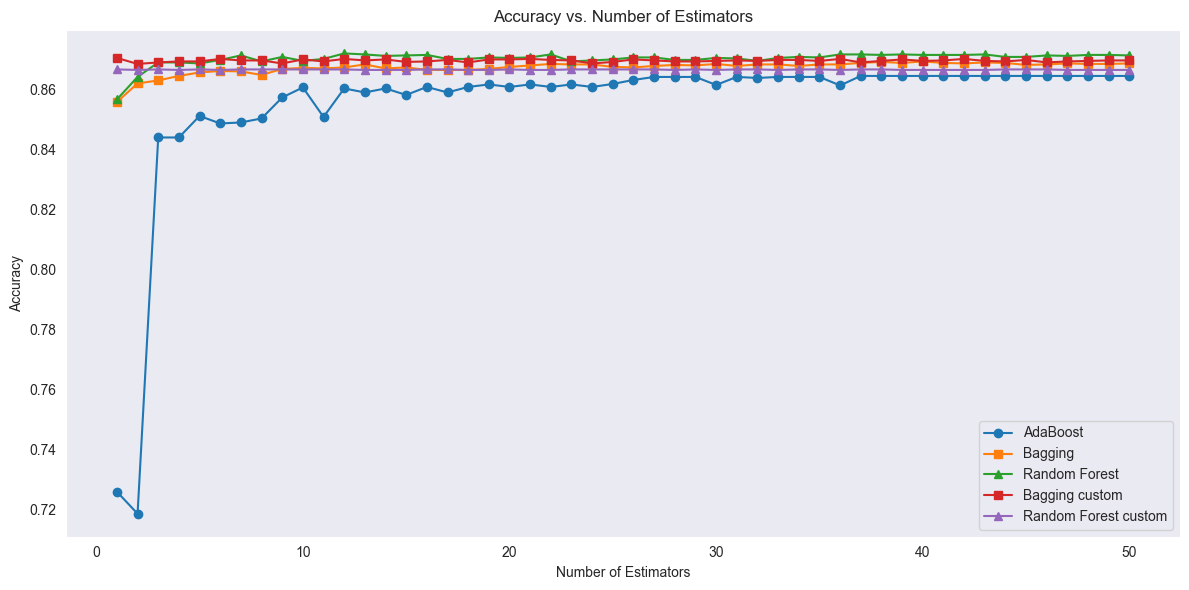

In [5]:
# Initialize models
max_estimators = 50
estimators_range = range(1, max_estimators + 1)

ada_accuracies = []
bagging_accuracies = []
rf_accuracies = []

bagging_custom_accuracies = []
rf_custom_accuracies = []

# Train and evaluate each model for different numbers of estimators
for n_estimators in estimators_range:
    # AdaBoost
    ada = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=n_estimators,
        random_state=42,
        algorithm='SAMME',
    )
    ada.fit(X_train, y_train)
    ada_preds = ada.predict(X_test)
    ada_accuracies.append(accuracy_score(y_test, ada_preds))

    # Bagging
    bagging = BaggingClassifier(
        estimator=RandomForestClassifier(),
        n_estimators=n_estimators,
        random_state=42,
        bootstrap=True, max_features=1.0, max_samples=0.5
    )
    bagging.fit(X_train, y_train)
    bagging_preds = bagging.predict(X_test)
    bagging_accuracies.append(accuracy_score(y_test, bagging_preds))

    bagging_custom = Bagging(base_model=RandomForestClassifier,
                             n_estimators=n_estimators,
                             random_state=42,
                             max_depth=7, max_samples=1.0, min_samples_split=15)
    bagging_custom.fit(X_train, y_train)
    bagging_custom_preds = bagging_custom.predict(X_test)
    bagging_custom_accuracies.append(accuracy_score(y_test, bagging_custom_preds))

    # Random Forest
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=42,
        bootstrap=True, max_depth=10, max_features='sqrt', min_samples_leaf=2, min_samples_split=2
    )
    rf.fit(X_train, y_train)
    rf_preds = rf.predict(X_test)
    rf_accuracies.append(accuracy_score(y_test, rf_preds))

    rf_custom = RandomForest(
        n_estimators=n_estimators,
        random_state=42,
        max_depth= 7, max_features= 0.7, min_samples_split= 5
    )
    rf_custom.fit(X_train, y_train)
    rf_custom_preds = rf_custom.predict(X_test)
    rf_custom_accuracies.append(accuracy_score(y_test, rf_custom_preds))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(estimators_range, ada_accuracies, label='AdaBoost', marker='o')
plt.plot(estimators_range, bagging_accuracies, label='Bagging', marker='s')
plt.plot(estimators_range, rf_accuracies, label='Random Forest', marker='^')

plt.plot(estimators_range, bagging_custom_accuracies, label='Bagging custom', marker='s')
plt.plot(estimators_range, rf_custom_accuracies, label='Random Forest custom', marker='^')

plt.title('Accuracy vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()